# Plot Periodic Hill Results for SST-IDDES model
## Run sst_iddes_02

In [1]:
%%capture
import sys
import os
sys.path.insert(1, '../utilities')
import utilities
import plotter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import copy

In [2]:
figsize=(15,6)

# Setup directories
# Reference data
refdir = os.path.abspath("../marchdf.periodicHill/refdata")

basestyle= {'lw':1.25,  'ls':'-', 'marker':None, 'color':'r', 
            'mfc':plotter.cmap[-1], 'mec':plotter.cmap[-1], 'ms':3,}

# Put all Nalu-Wind directories to plot here
fdirlist=[
        # Directory                Input file                      Legend suffix   Linestyle
        #['../sst/',                'periodicHill_sst.yaml',        '',             basestyle],
        ['../sst_iddes_02/',       'periodicHill_sstiddes.yaml',   'ORIG',       {**basestyle, **dict(color='b')}],
        ['',                       'periodicHill_sstiddes.yaml',   'RERUN',      {**basestyle, **dict(color='r', ls='--')}],
         ]

In [3]:
# Define the data, styles, and the legend
expdict  = {'data':plotter.read_exp_data(os.path.join(refdir, "exp")), 'label':"EXP",
            'lw':0, 'marker':plotter.markertype[2], 'color':plotter.cmap[-1], 
            'mfc':plotter.cmap[-1], 'mec':plotter.cmap[-1], 'ms':3, 'xoff':1.0}

lesdict  = {'data':plotter.read_les_data(os.path.join(refdir, "les")),  'label':"LES",
            'lw':2.5, 'marker':None, 'color':plotter.cmap[2], 
            'mfc':plotter.cmap[-1], 'mec':plotter.cmap[-1], 'ms':0, 'xoff':1.0}

v2fdict  = {'data':plotter.read_cdp_data(os.path.join(refdir, "cdp-v2f")),'label':"CDP-v2f",
            'lw':2.5, 'marker':None, 'color':plotter.cmap[2], 
            'mfc':plotter.cmap[-1], 'mec':plotter.cmap[-1], 'ms':0, 'xoff':0.0 }

tamsdict = {'data':plotter.read_cdp_data(os.path.join(refdir, "cdp-tams")),'label':"CDP-v2f-TAMS",
            'lw':2.5, 'marker':None, 'color':plotter.cmap[3], 
            'mfc':plotter.cmap[-1], 'mec':plotter.cmap[-1], 'ms':0, 'xoff':0.0 }

# Comment out the data series you don't want to plot
data2plot = [expdict, 
             lesdict,
             #v2fdict,
             #tamsdict,
            ]

## Plot velocity profiles

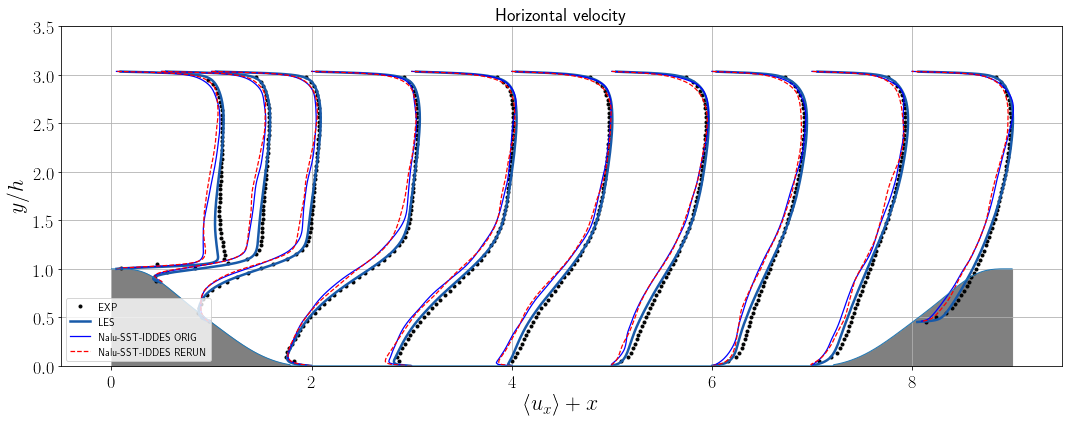

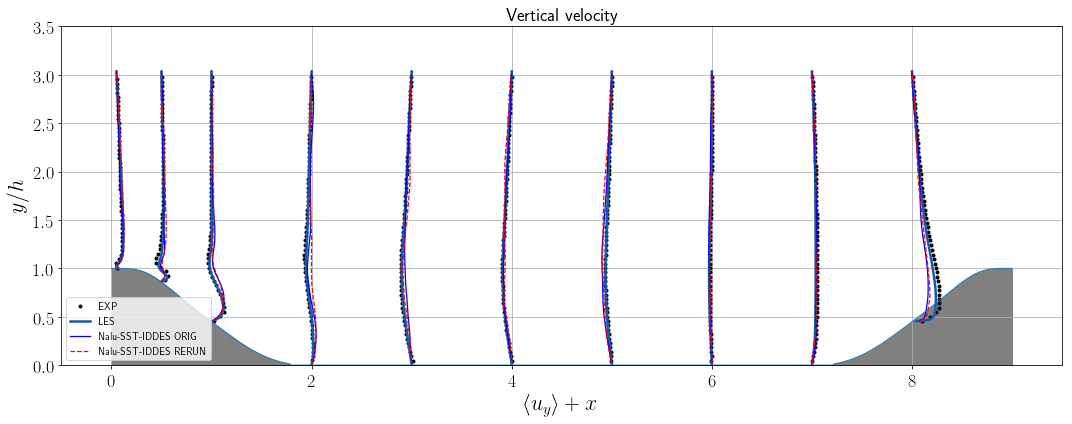

In [4]:
legend_elements=[]

# Loop through and plot each dataseriese
for ds in data2plot:
    grouped = ds['data'].groupby(["x"])
    xoffset = ds['xoff']
    legend_elements += [
        Line2D([0], [0], lw=ds['lw'], marker=ds['marker'], color=ds['color'], mfc=ds['mfc'], mec=ds['mec'], markersize=ds['ms'], label=ds['label'], ),
    ]
    #print(ds['data'].columns.tolist())
    for k, (name, group) in enumerate(grouped):
        idx = group.y.values >= utilities.hill(group.x.values)
        if ("u" in ds['data'].columns.tolist()): 
            plt.figure("u", figsize=figsize)
            p = plt.plot(group[idx].u + xoffset*group[idx].x, group[idx].y, 
                         lw=ds['lw'], color=ds['color'], marker=ds['marker'], mec=ds['mec'], mfc=ds['mfc'], ms=ds['ms'], )
        if ("v" in ds['data'].columns.tolist()): 
            plt.figure("v", figsize=figsize)
            p = plt.plot(group[idx].v + xoffset*group[idx].x, group[idx].y,
                         lw=ds['lw'], color=ds['color'], marker=ds['marker'], mec=ds['mec'], mfc=ds['mfc'], ms=ds['ms'], )

# Nalu data
for i, fdirentry in enumerate(fdirlist):
    fdir     = fdirentry[0]
    yamlfile = fdirentry[1]
    suffix   = fdirentry[2]
    style    = fdirentry[3]
    yname = os.path.join(os.path.dirname(fdir), yamlfile)
    u0, rho0, mu, turb_model = plotter.parse_ic(yname)
    model = turb_model.upper().replace("_", "-")
    legend_elements += [ Line2D([0], [0], lw=style['lw'], ls=style['ls'], color=style['color'], label=f"Nalu-{model} "+suffix,
                               marker=style['marker'],  mfc=style['mfc'], mec=style['mec'], markersize=style['ms']) ]

    ndf = pd.read_csv(os.path.join(fdir, "profiles.dat"))
    ndf.loc[ndf.u > 5, ["u", "v", "w"]] = 0.0
    grouped = ndf.groupby(["x"])
    for k, (name, group) in enumerate(grouped):
        idx = group.y.values >= utilities.hill(group.x.values)
        plt.figure("u")
        p = plt.plot(group[idx].u + group[idx].x, group[idx].y, lw=style['lw'], ls=style['ls'], color=style['color'],
                    marker=style['marker'],  mfc=style['mfc'], mec=style['mec'], markersize=style['ms'])

        plt.figure("v")
        p = plt.plot(group[idx].v + group[idx].x, group[idx].y, lw=style['lw'], ls=style['ls'], color=style['color'],
                    marker=style['marker'],  mfc=style['mfc'], mec=style['mec'], markersize=style['ms'])


x = np.linspace(0,9,1001)

# Set up the U-velocity plot
plt.figure("u")
ax = plt.gca()
plt.plot(x, utilities.hill(x), lw=1)
plt.fill_between(x, utilities.hill(x),0, color='gray')
plt.xlabel(r"$\langle u_x \rangle + x$", fontsize=22, fontweight="bold")
plt.ylabel(r"$y / h$", fontsize=22, fontweight="bold")
plt.setp(ax.get_xmajorticklabels(), fontsize=18, fontweight="bold")
plt.setp(ax.get_ymajorticklabels(), fontsize=18, fontweight="bold")
plt.xlim([-0.5, 9.5])
plt.ylim([0, 3.5])
legend = ax.legend(handles=legend_elements, loc="lower left")
plt.grid()
plt.title('Horizontal velocity', fontsize=18)
plt.tight_layout()

# Set up the V-velocity plot
plt.figure("v")
ax = plt.gca()
plt.plot(x, utilities.hill(x), lw=1)
plt.fill_between(x, utilities.hill(x),0, color='gray')
plt.xlabel(r"$\langle u_y \rangle + x$", fontsize=22, fontweight="bold")
plt.ylabel(r"$y / h$", fontsize=22, fontweight="bold")
plt.setp(ax.get_xmajorticklabels(), fontsize=18, fontweight="bold")
plt.setp(ax.get_ymajorticklabels(), fontsize=18, fontweight="bold")
plt.xlim([-0.5, 9.5])
plt.ylim([0, 3.5])
legend = ax.legend(handles=legend_elements, loc="best")
plt.grid()
plt.title('Vertical velocity', fontsize=18)
plt.tight_layout()



## Plot surface & time history of Nalu-Runs

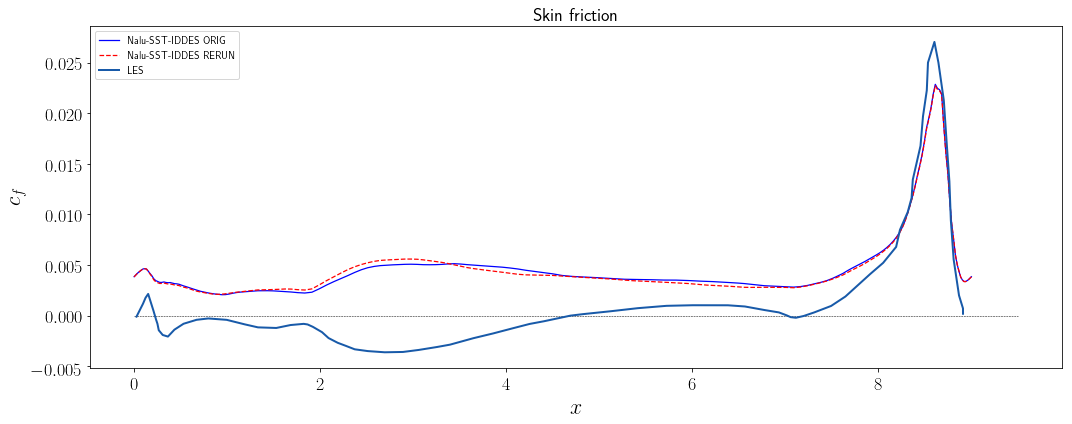

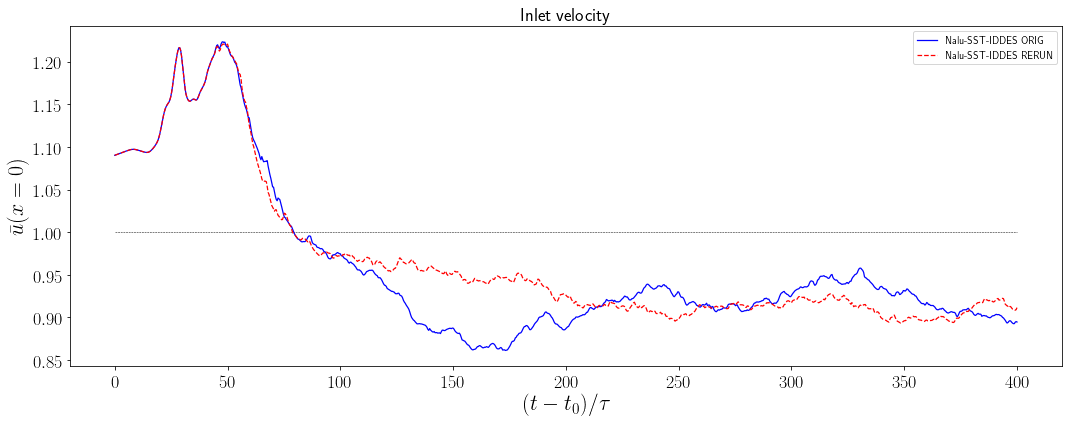

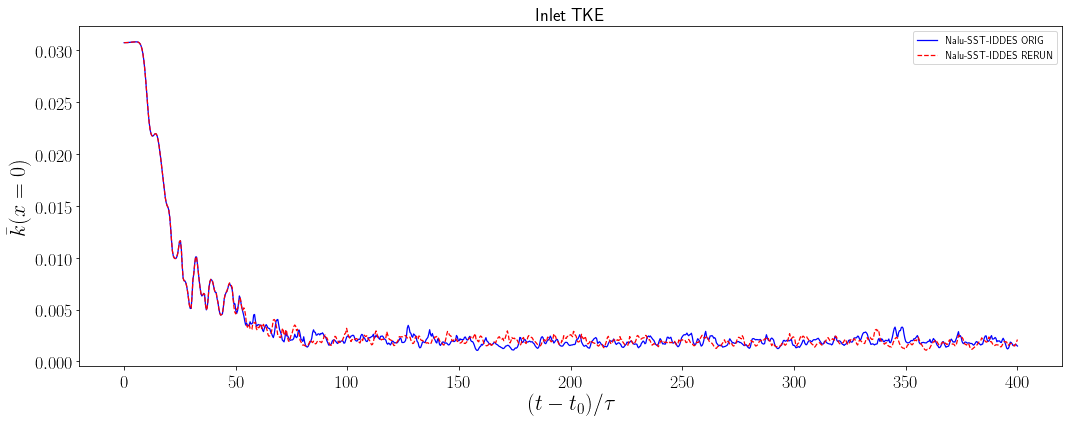

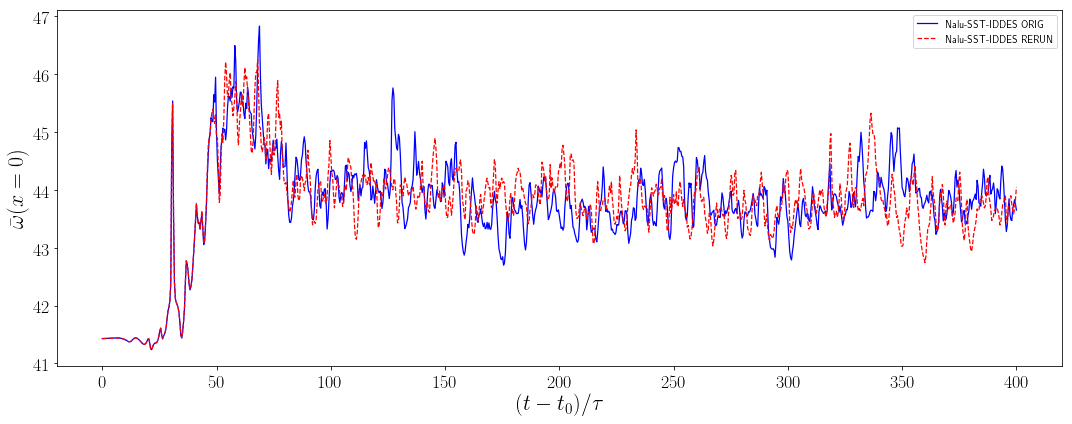

In [5]:
# Nalu data
maxt=-1.0E100
for i, fdirentry in enumerate(fdirlist):
    fdir     = fdirentry[0]
    yamlfile = fdirentry[1]
    suffix   = fdirentry[2]
    style    = fdirentry[3]
    yname = os.path.join(os.path.dirname(fdir), yamlfile)
    u0, rho0, mu, turb_model = plotter.parse_ic(yname)
    model = turb_model.upper().replace("_", "-")
    legend_elements += [ Line2D([0], [0], lw=style['lw'], ls=style['ls'], color=style['color'], label=f"Nalu-{model} "+suffix,
                               marker=style['marker'],  mfc=style['mfc'], mec=style['mec'], markersize=style['ms'])    ]

    h = 1.0
    tau = h / u0
    dynPres = rho0 * 0.5 * u0 * u0
    ndf = pd.read_csv(os.path.join(fdir, "profiles.dat"))
    ndf.loc[ndf.u > 5, ["u", "v", "w"]] = 0.0
    grouped = ndf.groupby(["x"])
    
    cf = pd.read_csv(os.path.join(fdir, "tw.dat"))
    cf["cf"] = cf.tauw / dynPres
    plt.figure("cf", figsize=figsize)
    plt.plot(cf.x, cf.cf, lw=style['lw'], ls=style['ls'], color=style['color'], label=f"Nalu-{model} "+suffix,
            marker=style['marker'],  mfc=style['mfc'], mec=style['mec'], markersize=style['ms'])

    inlet = pd.read_csv(os.path.join(fdir, "inlet.dat"))
    plt.figure("u_inlet", figsize=figsize)
    plt.plot((inlet.t-inlet.t[0]) / tau, inlet.u, lw=style['lw'], ls=style['ls'], color=style['color'], label=f"Nalu-{model} "+suffix,
            marker=style['marker'],  mfc=style['mfc'], mec=style['mec'], markersize=style['ms'])

    plt.figure("tke_inlet", figsize=figsize)
    plt.plot((inlet.t-inlet.t[0]) / tau, inlet.tke, lw=style['lw'], ls=style['ls'], color=style['color'], label=f"Nalu-{model} "+suffix,
            marker=style['marker'],  mfc=style['mfc'], mec=style['mec'], markersize=style['ms'])

    plt.figure("sdr_inlet", figsize=figsize)
    plt.plot((inlet.t-inlet.t[0]) / tau, inlet.sdr, lw=style['lw'], ls=style['ls'], color=style['color'], label=f"Nalu-{model} "+suffix,
            marker=style['marker'],  mfc=style['mfc'], mec=style['mec'], markersize=style['ms'])
    
    # Get the simulation time
    if (max((inlet.t-inlet.t[0]) / tau) > maxt): maxt=max((inlet.t-inlet.t[0]) / tau)

# Plot the LES cf
ldir = os.path.join(refdir, "les")
cf = pd.read_csv(os.path.join(ldir, "hill_LES_cf_digitized.dat"), delim_whitespace=True)
plt.figure("cf")
plt.plot(cf.x, cf.cf, lw=2, color=plotter.cmap[2], label="LES")

    
# Format figures
plt.figure("cf")
ax = plt.gca()
plt.xlabel(r"$x$", fontsize=22, fontweight="bold")
plt.ylabel(r"$c_f$", fontsize=22, fontweight="bold")
plt.setp(ax.get_xmajorticklabels(), fontsize=18, fontweight="bold")
plt.setp(ax.get_ymajorticklabels(), fontsize=18, fontweight="bold")
plt.hlines(0.0, 0, 9.5, linestyles='dashed', linewidth=0.5)
legend = ax.legend(loc="best")
plt.title('Skin friction', fontsize=18, fontweight="bold")
plt.tight_layout()

plt.figure("u_inlet")
ax = plt.gca()
plt.xlabel(r"$(t-t_0) / \tau$", fontsize=22, fontweight="bold")
plt.ylabel(r"$\bar{u} (x=0)$", fontsize=22, fontweight="bold")
plt.setp(ax.get_xmajorticklabels(), fontsize=18, fontweight="bold")
plt.setp(ax.get_ymajorticklabels(), fontsize=18, fontweight="bold")
plt.hlines(1.0, 0, maxt, linestyles='dashed', linewidth=0.5)
legend = ax.legend(loc="best")
plt.title('Inlet velocity', fontsize=18, fontweight="bold")
plt.tight_layout()

plt.figure("tke_inlet")
ax = plt.gca()
plt.xlabel(r"$(t-t_0) / \tau$", fontsize=22, fontweight="bold")
plt.ylabel(r"$\bar{k} (x=0)$", fontsize=22, fontweight="bold")
plt.setp(ax.get_xmajorticklabels(), fontsize=18, fontweight="bold")
plt.setp(ax.get_ymajorticklabels(), fontsize=18, fontweight="bold")
legend = ax.legend(loc="best")
plt.title('Inlet TKE', fontsize=18, fontweight="bold")
plt.tight_layout()

plt.figure("sdr_inlet")
ax = plt.gca()
plt.xlabel(r"$(t-t_0) / \tau$", fontsize=22, fontweight="bold")
plt.ylabel(r"$\bar{\omega} (x=0)$", fontsize=22, fontweight="bold")
plt.setp(ax.get_xmajorticklabels(), fontsize=18, fontweight="bold")
plt.setp(ax.get_ymajorticklabels(), fontsize=18, fontweight="bold")
legend = ax.legend(loc="best")
plt.tight_layout()
